### Data generator function for the classification+location problem: electrons, muons and alphas

In [1]:
import glob
import os, shutil
import matplotlib.pyplot as plt
import numpy as np

To generate the data, we already have a directory containing the data from electrons, alphas, noise and muons (`/gpfs/projects/damic/eVSmuVSa_Loc`). Previously all the files from each class were in different directories (`cropped_electrons4`, `cropped_alphas4`, `cropped_muons4`) 

In [2]:
path = '/gpfs/projects/damic/eVSmuVSa_Loc'

In [3]:
num_files = len([f for f in os.listdir(path)if os.path.isfile(os.path.join(path, f))])
print('We have', num_files,'files')

num_electrons = len(glob.glob1(path,"*11.npz"))
num_noise = len(glob.glob1(path,"noise*"))
num_muons = len(glob.glob1(path,"*13.npz"))
num_alphas = len(glob.glob1(path,"*1000020040.npz"))

print('There are',num_electrons,'electrons,', num_muons,'muons,',num_alphas, 'alphas and',num_noise,'files with noise')

We have 18277 files
There are 5835 electrons, 5224 muons, 7218 alphas and 0 files with noise


Now we define our data generator function:

In [4]:
def data_generator(inputs, targets, batch_size, num_classes, train_split, val_split, test_split, shuffle=True):
    
    #checking the parameters
    assert len(inputs) == len(targets)
    assert len(inputs) >= batch_size
    assert train_split + val_split + test_split == 1
    
    # Create list of indices
    idxs = np.arange(len(inputs))
    if shuffle:
        np.random.shuffle(idxs)

    # Reshape targets to the correct shape
    if len(targets.shape) == 1:
        print('reshaping targets')
        targets = targets.reshape(-1, 1)
        
    num_batch = 0 #index for the batches
    
    batch_tot = len(range(0, len(inputs) - batch_size + 1, batch_size)) #total number of batches

    #creating the batchs 
    for start_idx in range(0, len(inputs) - batch_size + 1, batch_size):
        excerpt = idxs[start_idx:start_idx + batch_size]
        batch_X = []
        batch_y = []
        batch_loc = []
        
        for i in excerpt:
            im = np.load(inputs[i])['energy']
            batch_X.append(im)  # shape (N, 242, 192)
            
            #putting labels as categorical
            lab = int(targets[i])
            batch_y.append(np.eye(num_classes)[lab])
            
            #calculating the position of the box where is located the track
            coords = np.argwhere(im) #coordinates of non zero elements in the array
            y_min, x_min = coords.min(axis=0) #coordinates of the element located on the left bottom
            y_max, x_max = coords.max(axis=0) #coordinates of the element located on the right top
            loc_a = x_min, y_min, y_max-y_min, x_max-x_min
            
            #putting the locations of tracks in a matrix
            batch_loc.append(loc_a)
     
        batch_X = np.array(batch_X) #shape (batch_size, 242, 192)
        
        #creating batch of labels
        batch_y = np.asarray(batch_y)
        
        batch_loc = np.asarray(batch_loc)
        
        num_batch += 1
        print(num_batch)
        a = num_batch/batch_tot
        
        #saving the batch in the corresponding directory (train, validation or test)
        if  a >= (train_split + val_split):
            np.savez('/gpfs/projects/damic/eVSmuVSa_LocTest/batch%d' % num_batch, X = batch_X, y = batch_y, loc = batch_loc)
        elif a > (train_split):
            np.savez('/gpfs/projects/damic/eVSmuVSa_LocVal/batch%d' % num_batch, X = batch_X, y = batch_y, loc = batch_loc)
        else:
            np.savez('/gpfs/projects/damic/eVSmuVSa_LocTrain/batch%d' % num_batch, X = batch_X, y = batch_y, loc = batch_loc)

In [5]:
files = os.listdir(path)

files[0:10]

['ColdCopper_3_PV_PV_208a81z_s14_N100000_image_evt_71403_ccd_1_ind_1_pdg_11.npz',
 'ColdCopper_mu+_5p0GeV_N10000_image_evt_7500_ccd_1_ind_3_pdg_-13.npz',
 'CCDSensor_PV_alpha_inBulk_10p0MeVeV_N300_image_evt_139_ccd_2_ind_0_pdg_1000020040.npz',
 'CCDSensor_PV_alpha_inBulk_1p0MeVeV_N300_image_evt_240_ccd_1_ind_0_pdg_1000020040.npz',
 'ColdCopper_mu+_3p0GeV_N10000_image_evt_9173_ccd_2_ind_2_pdg_-13.npz',
 'CCDSensor_PV_alpha_inBulk_5p0MeVeV_N300_image_evt_201_ccd_2_ind_0_pdg_1000020040.npz',
 'ColdCopper_3_PV_PV_60a27z_s41_N100000_image_evt_67738_ccd_2_ind_0_pdg_11.npz',
 'CCDSensor_PV_alpha_inBulk_3p0MeVeV_N300_image_evt_198_ccd_2_ind_0_pdg_1000020040.npz',
 'CCDSensor_PV_alpha_inBulk_8p0MeVeV_N300_image_evt_38_ccd_1_ind_0_pdg_1000020040.npz',
 'ColdCopper_3_PV_PV_212a83z_s73_N100000_image_evt_35864_ccd_1_ind_0_pdg_11.npz']

In [6]:
type(files[0])

str

In [7]:
e_suffix = '11.npz'

files[0].endswith(e_suffix)

True

Let's generate the labels with the method `endswith`, where 0 stands for nosie, 1 for electron and 2 for muons:

In [8]:
y = np.zeros(shape=(len(files),))

In [9]:
mu_suffix = '13.npz'

a_suffix = '1000020040.npz'

In [10]:
for index, file in enumerate(files):     
    if files[index].endswith(e_suffix) == True:
        y[index] = 0 #electron
    elif files[index].endswith(mu_suffix) == True:
        y[index] = 1 #muons
    elif files[index].endswith(a_suffix) == True:
        y[index] = 2 #alphas

In [11]:
y[0:10]

array([0., 1., 2., 2., 1., 2., 0., 2., 2., 0.])

Now we generate the paths of the numpy files:

In [12]:
X = np.empty(shape=(len(files),), dtype=object)

for index, file in enumerate(files):     

    X[index] = os.path.join(path, files[index]) 

In [13]:
X

array(['/gpfs/projects/damic/eVSmuVSa_Loc/ColdCopper_3_PV_PV_208a81z_s14_N100000_image_evt_71403_ccd_1_ind_1_pdg_11.npz',
       '/gpfs/projects/damic/eVSmuVSa_Loc/ColdCopper_mu+_5p0GeV_N10000_image_evt_7500_ccd_1_ind_3_pdg_-13.npz',
       '/gpfs/projects/damic/eVSmuVSa_Loc/CCDSensor_PV_alpha_inBulk_10p0MeVeV_N300_image_evt_139_ccd_2_ind_0_pdg_1000020040.npz',
       ...,
       '/gpfs/projects/damic/eVSmuVSa_Loc/ColdCopper_mu+_7p0GeV_N10000_image_evt_3622_ccd_2_ind_0_pdg_-13.npz',
       '/gpfs/projects/damic/eVSmuVSa_Loc/ColdCopper_3_PV_PV_56a27z_s72_N100000_image_evt_31450_ccd_2_ind_0_pdg_11.npz',
       '/gpfs/projects/damic/eVSmuVSa_Loc/ColdCopper_mu+_5p0GeV_N10000_image_evt_7140_ccd_2_ind_7_pdg_-13.npz'],
      dtype=object)

Now we generate the data:

In [ ]:
data_gen =  data_generator(inputs=X, targets=y, batch_size=64, num_classes=3, train_split = 0.6, 
                           val_split = 0.2, test_split = 0.2, shuffle=True)

#history = model.fit_generator(generator=train_gen, ...) -> in local

batch31.npz


Text(0.5, 1.0, 'Energy')

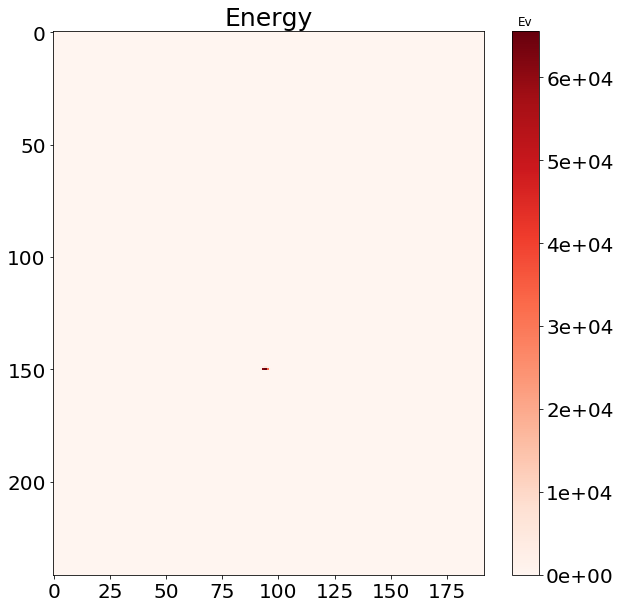

In [15]:
original_dataset_dir = '/gpfs/projects/damic/eVSmuVSa_LocTrain/'

files = os.listdir(original_dataset_dir)
f=76
e = np.load(os.path.join(original_dataset_dir, files[f]))['X']
print(files[f])
e = e.reshape((e.shape[0], e.shape[1], e.shape[2]))[60]

fig_e = plt.figure(figsize=(10,10))
plt.imshow(e, cmap='Reds')
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20)
cb = plt.colorbar(format='%.0e')
cb.ax.set_title('Ev')
cb.ax.tick_params(labelsize=20)
plt.title("Energy", fontsize = 25)

In [16]:
e.shape

(242, 192)

In [17]:
e.std()

445.0257716410495

In [18]:
np.load(os.path.join(original_dataset_dir, files[f]))['y'][60] #alpha particle

array([0., 0., 1.])

In [19]:
np.load(os.path.join(original_dataset_dir, files[f]))['loc'][60] #location of the alpha particle

array([ 91, 148,   2,   5])